In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set()

from stop_permuting_features.src.utils import get_lr

In [2]:
from typing import Dict
import collections

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr

import shap
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMModel


Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.


In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
from stop_permuting_features.src.generate_data import (
    generate_weights_gamma,
    get_correlated_data_stats,
    generate_normal_correlated_data,
    generate_normal_target
)

In [5]:
from sklearn.model_selection import ParameterGrid

In [6]:
num_seeds = 10

In [7]:
def run_experiment(
        experiment_params: Dict[str, any]
) -> Dict[str, float]:
    experiment_results = collections.OrderedDict()

    # generate data
    data = generate_normal_correlated_data(
        mu=experiment_params["mu"],
        var=experiment_params["var"],
        n_features=experiment_params["n_features"],
        n_samples=experiment_params["n_samples"],
        max_correlation=experiment_params["max_correlation"],
        noise_magnitude_max=experiment_params["noise_magnitude_max"],
        seed=experiment_params["seed"]
    )
    
    data_stats = get_correlated_data_stats(data)
    return data_stats

In [8]:
    experiments_grid = ParameterGrid(
        {
            "task": ["classification"],

            # constant params - data generation
            "mu": [0],
            "var": [1],
            "n_features": [50],
            "n_samples": [10_000],

            # constant params - weights
            "gamma": [1],
            "scale": [1],

            # permutation params
            "metric": [roc_auc_score],  # "negative_mean_squared_error" for regression, "roc_auc_score" for classification
            "model_params": [
                {
                    "objective": "binary",  # "regression" for regression, "binary" for classification
                    "learning_rate": 0.01,
                    "n_estimators": 100,
                    "random_state": 42
                }
            ],
            "n_repeats_permutations": [5],

            # changeable params
            "max_correlation": [0.95, 0.9, 0.8, 0.7, 0.6],
            "noise_magnitude_max": np.arange(1, 5, 1),
            "seed": list(range(num_seeds)),
        }
    )
    experiments_grid = list(experiments_grid)

    # run experiments
    results = []
    for experiment_params in tqdm(experiments_grid):
        experiment_results = run_experiment(experiment_params)
        results.append(experiment_results)

100%|██████████| 200/200 [01:05<00:00,  3.06it/s]


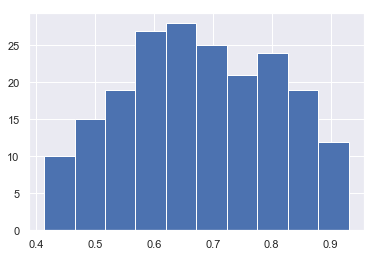

In [9]:
pd.DataFrame(results)["abs_correlation_mean"].hist()